#### __ __ __ __ __Этапы решения__ __ __ __ __ __ __ __ ___ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __Public Score__ __ __ __ __

    1) Нахождение двух пиков в автокорреляции: 288 и 2016.
        - C помощью tsaplots.plot_acf были найдены общие для всех рядов
           точки максимума.
           
    2) Предсказанием является значение 288 измерений назад                          2.528
        - Наивный метод "сегодня как вчера"
        
    3) Выбор среднего по всем имеющимся данным за прошлые недели,                   2.216
    соответствующим предсказываемому временному промежутку.
        - С какого-то момента глобально поведение временного ряда могло 
        измениться
        - Значения временного ряда для некоторых недель могут 
        быть совсем нетипичными
        - Необходимо доработать решение
        
    4) Значение соответствующее предыдущей неделе                                   2.18879
        - Соответствие не только по времени, но и по дню недели позволяет 
          улучшить результат пункта 2.
          
    5) Эксперименты с AutoARIMA                                                     Failed
        - Большая длина сезонности не позволяет алгоритму сходиться
        и корректно работать, получены лишь константные предсказания.
        
-- Первый бейслайн пройден --

    6) Выбор наилучшего подхода из пунктов 2 и 4 для каждого из рядов               2.161
    (типа _1)
        - Ошибочное предположение о важности только этих временных рядов из-за
        полученных весов для подсчета метрики MASE.
        
    7) Выбор наилучшего подхода для каждого из рядов                                2.038
       - Из-за того, что логически более обоснованным является использование
       4), была произведена попытка выбора подхода на основании
       полученных ошибок, умноженных на константу большую единицы для 2).
       
    8) Возвращение к AutoARIMA, экспоненциальное сглаживание                        Failed
    - Попытка сокращения временных рядов до промежутков в 24 часа для
    сходимости (seasonal_length 2016 -> 7)
    
    9) Выбор из прошлой недели, прошлого дня и позавчерашнего дня                   Failed
    (расширение 7) )
    
    10) Выбор из прошлой недели и прошлого дня со сдвигом на [-10,...,10]           Failed
    временных отрезков.
    - На графиках для плохо предсказываемых рядов при наложении значений
    предыдущих дней иногда было заметно небольшое отставание или 
    опережение.
    
    11) Использование 4) с коррекцией, соответствующей ошибке в                     Failed
    предсказании предыдущего дня с помощью предыдущего дня на прошлой неделе.
    - Идея основана на принятии во внимания изменения тренда относительно
    прошлой недели
    
    12) Использование 6) с вычитанием медианы всех разностей в предсказании         Failed
    последних 100 значений для временного ряда
    - С одной стороны, позволяет уловить тренд
    - С другой стороны, переобучение, ориентация на минимизацию не тех величин
    
    13) Ручной анализ подходящего дня для плохо аппроксимирующихся                  2.021
    временных рядов
    - Подбор на основании графика хорошего дня для предсказания
    - Если бы ошибка накапливалась на определенном ряду, 
    могло бы существенно помочь
    
    14) Выбор дня, наиболее удачным образом предсказывающего последние              1.905
    100 временных промежутков. (Конечная точка пункта 6) )
    
    15) Сглаживание ответа (rolling(num).mean())                                    Failed
    - Казалось, что можно таким образом уменьшить ошибку для рядов, которые
    сложно предсказать. (Им присуща большая вариация)
    - Большой скачок между первым предсказанием и последним известным значением
    убрать не удалось.
    
    16) Выбор среднего из записей, соответствующих 25% дням, хорошо                 1.651
    аппроксимирующим последние 100 временных промежутков (возвращение
    к пункту 3))
    - Выбор процента на основании ошибки
    - Полностью совпадающие с какой-то из предыдущих недель ряды 
    (ошибка 0 в 14) ) таким образом не предсказываем.
    
-- Второй бейслайн пройден --

-- ЛЧ на привате пройдено --

Контроль:

Предсказание последних ста известных значений для каждого ряда, вычисление MASE, использованной в соревновании.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics import tsaplots

In [3]:
tr = pd.read_parquet('train.parquet')
sample_submission = pd.read_csv('submission.csv')

In [4]:
index_split = tr.index.str.split('_')

In [5]:
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type

In [6]:
X = tr.pivot(index='row_id', columns='timestamp', values='Values')

In [7]:
X.columns = ['tr_' + str(col) for col in X.columns]

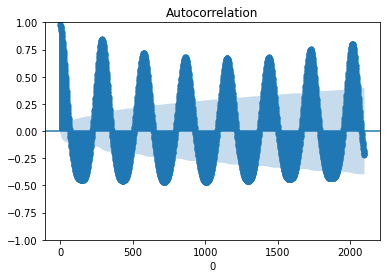

In [8]:
fig = tsaplots.plot_acf(X.iloc[0, :], lags=np.arange(2100))
plt.xlabel(0)
plt.show()

In [9]:
w = np.sum(np.abs(X.diff(periods=1, axis=1)), axis=1)/17754
w = 1/w

In [10]:
idx = np.arange(510)
res1 = np.zeros((idx.size,50))
error1 = 0
s = np.zeros((idx.size,100))
for j in range(50):
    for i in idx:
        res1[i][j] = w[i]*np.sum(np.abs(X.iloc[i][-100-288*(j+1):-288*(j+1)].to_numpy()-X.iloc[i][-100:].to_numpy()))/10000

In [11]:
not_zero = idx[res1.min(axis=1)>0]
d ={}

for i in not_zero:
    d[i] = np.arange(50)[res1[i,:] < np.percentile(res1[i,:], 25)]

In [12]:
# Ручное исследование плохо аппроксимирующихся рядов
# for el in not_good:
#     sns.lineplot(x=np.arange(2300), y=X.iloc[el,-2300:], n_boot=0)
#     sns.lineplot(x=np.arange(100), y=X.iloc[el,-2116:-2016].rolling(5).mean(), n_boot=0, color="blue")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el,-388:-288], n_boot=0, color="orange")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el,-100:],linewidth = 4, n_boot=0, color="green")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -676:-576], n_boot=0, color="black")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -4132:-4032].to_numpy(), n_boot=0, color="purple")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -6148:-6048].to_numpy(), n_boot=0, color="yellow")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -8164:-8064].to_numpy(), n_boot=0, color="grey")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -10180:-10080].to_numpy(), n_boot=0, color="red")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -12196:-12096].to_numpy(), n_boot=0, color="lime")
#     sns.lineplot(x=np.arange(100), y=X.iloc[el, -14212:-14112].to_numpy(), n_boot=0, color="pink")
#     #sns.lineplot(x=np.arange(100)+2200, y=X.iloc[220, -100-1916-2016:-1916-2016], n_boot=0)
#     plt.gcf().set_size_inches(40, 15)
#     plt.show()

In [ ]:
for i in range(100):
        X.loc[:, f'pred_{i}'] = X.iloc[:, -2016]

In [14]:
indices = X.index

In [15]:
for i in not_zero:
    a = np.zeros(100)
    k = 0
    for val in d[i]:
        k += 1
        a += X.iloc[i, -100-288*(val+1):-288*(val+1)].to_numpy()
    a = a / k
    for j in range(100):
        X.loc[indices[i]][f'pred_{j}'] = a[j]

In [16]:
res = X.iloc[:, -100:].melt(ignore_index=False, value_name='Expected', var_name='pred_timestamp')
index_split_res = res.index.str.split('_')
res['row_num'] = index_split_res.str.get(0).astype(int)
res['row_type'] = index_split_res.str.get(1).astype(int)
res['timestamp'] = res.pred_timestamp.str.split('_').str.get(1).astype(int)
res['Id'] = res.index + '_' + res.timestamp.astype(str)
res.sort_values(['row_num', 'row_type', 'timestamp'], inplace=True)
res = res[['Id', 'Expected']].reset_index(drop=True)

In [17]:
res.to_csv('submission14.csv', index=False)